In [222]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xml.etree.ElementTree as ET

from collections import defaultdict, Counter

# ETS allowance exploration

## Load data

In [40]:
YEARS = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

In [4]:
tree = ET.parse('data/france_allowances_phase3.xml')
root = tree.getroot()

## Data exploration

In [29]:
installationNodes = root.findall(".//AllocationTableOperatorInformationPublic/AllocationTableOperatorInformation")

In [37]:
class Installation:
    def __init__(self, node):
        self.status = node.find('Status').text
        self.accountHolder = node.find('AccountHolderName').text
        self.installationName = node.find('InstallationName').text
        self.allocations = {}
        
        for year in YEARS:
            try:
                self.allocations[year] = int(node.find('allocation'+year).text)
            except:
                self.allocations[year] = None

In [38]:
installations = []
for installationNode in installationNodes:
    installations.append(Installation(installationNode))

In [225]:
rows = []
for installationNode in installationNodes:
    row = [
        installationNode.find('Status').text,
        installationNode.find('AccountHolderName').text,
        installationNode.find('InstallationName').text
    ]
    for year in YEARS:
        try:
            row.append(int(installationNode.find('allocation'+year).text))
        except:
            row.append(None)
    rows.append(row)

In [230]:
data = pd.DataFrame(
    rows,
    columns=[
        'Status',
        'AccountHolderName',
        'InstallationName',
        '2013',
        '2014',
        '2015',
        '2016',
        '2017',
        '2018',
        '2019',
        '2020'
    ]
)

In [231]:
data

,Status,AccountHolderName,InstallationName,2013,2014,2015,2016,2017,2018,2019,2020
0,Active,NESTLE FRANCE SAS,NESTLE FRANCE - Boué,18618.0,16661.0,22459.0,22046.0,21628.0,21206,20779,20351
1,Active,TEREOS FRANCE,Sucrerie de Bucy,84637.0,83167.0,81680.0,80177.0,78659.0,77125,75572,74013
2,Active,WEPA GREENFIELD SAS,WEPA GREENFIELD SAS,4599.0,4519.0,4438.0,4356.0,4274.0,4190,4106,4021
3,Permit Revoked,ARKEMA FRANCE,ARKEMA FRANCE - Usine de Chauny,64889.0,63762.0,0.0,0.0,0.0,0,0,0
4,Active,VERALLIA FRANCE,VERALLIA FRANCE - Vauxrot,58178.0,57167.0,56145.0,55113.0,54068.0,53014,51947,50875
5,Active,EVERBAL,PAPETERIE EVERBAL,15049.0,14571.0,14098.0,13630.0,13168.0,12712,12259,11814
6,Active,INTERSNACK FRANCE,Chaufferie INTERSNACK,9076.0,8122.0,7195.0,6294.0,5422.0,4579,3762,2976
7,Active,ROQUETTE FRERES SA,ROQUETTE VIC S.A.,15704.0,15431.0,15155.0,14876.0,14594.0,14310,14022,13733
8,Active,ENGIE ENERGIE SERVICES,ENGIE ENERGIE SERVICES Saint Quentin,10296.0,9214.0,8163.0,7145.0,6158.0,5204,4281,3391
9,Active,TEREOS FRANCE,Quotas CO² ORIGNY,191342.0,188019.0,184656.0,181259.0,177824.0,174357,170846,167323


### Number installations

In [229]:
data.shape

(1151, 11)

### Proportion of None or zero

In [239]:
for year in YEARS:
    p = len(list(filter(lambda x: x.allocations[year] is None or x.allocations[year] == 0, installations))) / len(installations)
    df = data[data[year] == 0]
    print('{}: {}'.format(year, df.shape[0] / data.shape[0]))

2013: 0.0677671589921807
2014: 0.07993049522154648
2015: 0.13292788879235448
2016: 0.1520417028670721
2017: 0.1737619461337967
2018: 0.19113814074717636
2019: 0.1998262380538662
2020: 0.20938314509122502


### Proportion of statuses

In [92]:
c = Counter([installation.status for installation in installations])
for key in c:
    print('{}: {}'.format(key, c[key] / len(installations)))

Active: 0.841876629018245
Permit Revoked: 0.158123370981755


### Total number of allocations per year

In [73]:
allocationsPerYear = defaultdict(list)
for installation in  installations:
    for year in installation.allocations:
        allocations = installation.allocations[year]
        if allocations is not None and allocations > 0:
            allocationsPerYear[year].append(allocations)

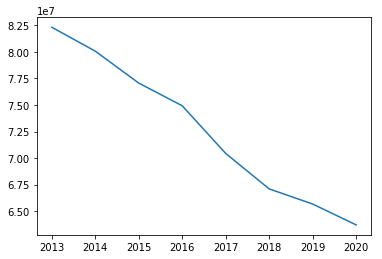

In [185]:
sums = [sum(allocationsPerYear[year]) for year in YEARS]
plt.plot(YEARS, sums)

### Relative yearly trend

(-0.1, 0)

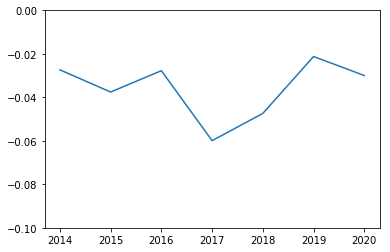

In [205]:
relativeTrends = [(sums[i+1] - sums[i]) / sums[i] for i in range(len(sums)-1)]
plt.plot(YEARS[1:], relativeTrends)
axes = plt.gca()
axes.set_ylim((-0.1, 0))

### Allocations distribution

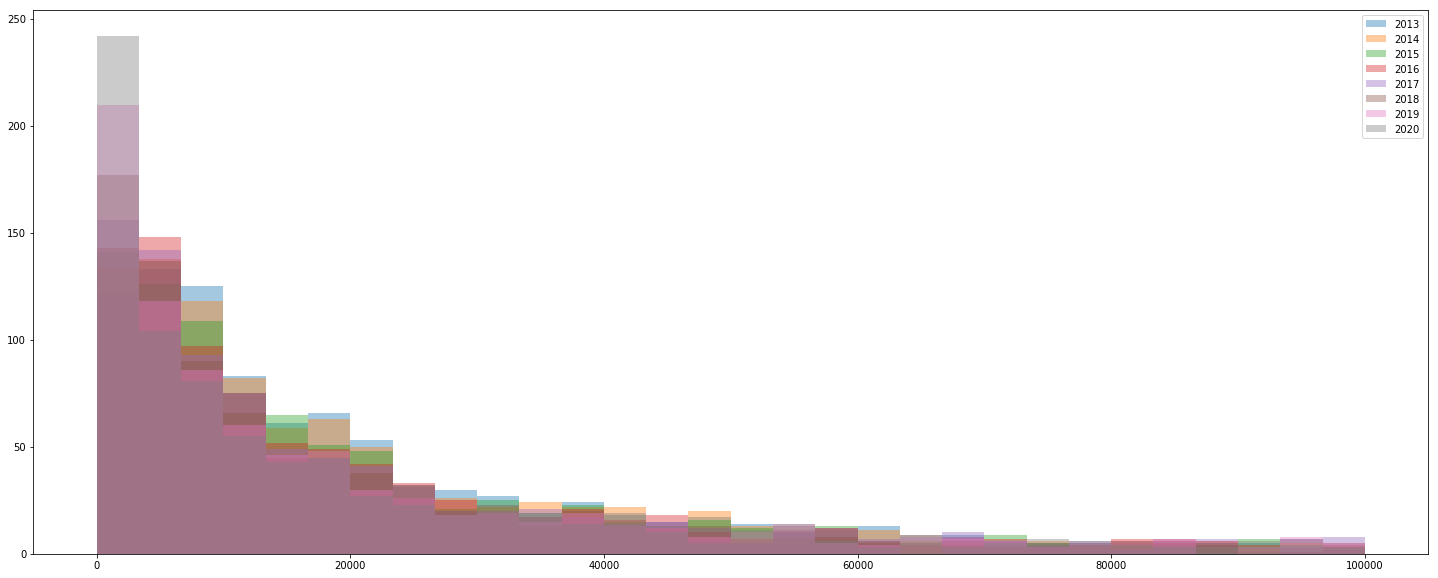

In [122]:
MIN, MAX = 0, 100000
plt.figure(figsize=(25,10))

for year in allocationsPerYear:
    filteredAllocations = list(filter(lambda x: x < MAX, allocationsPerYear[year]))
    sns.distplot(
        filteredAllocations,
        bins=30,
        kde=False,
        hist_kws={
            "range": (MIN, MAX)
        },
        label=year
    )
plt.legend()
plt.show()

In [221]:
plt.figure(figsize=(25,15))
sns.swarmplot(
    x=[[1,1,1,2,2,3]],
    y=[1]
)

TypeError: unhashable type: 'list'

#### Log distribution

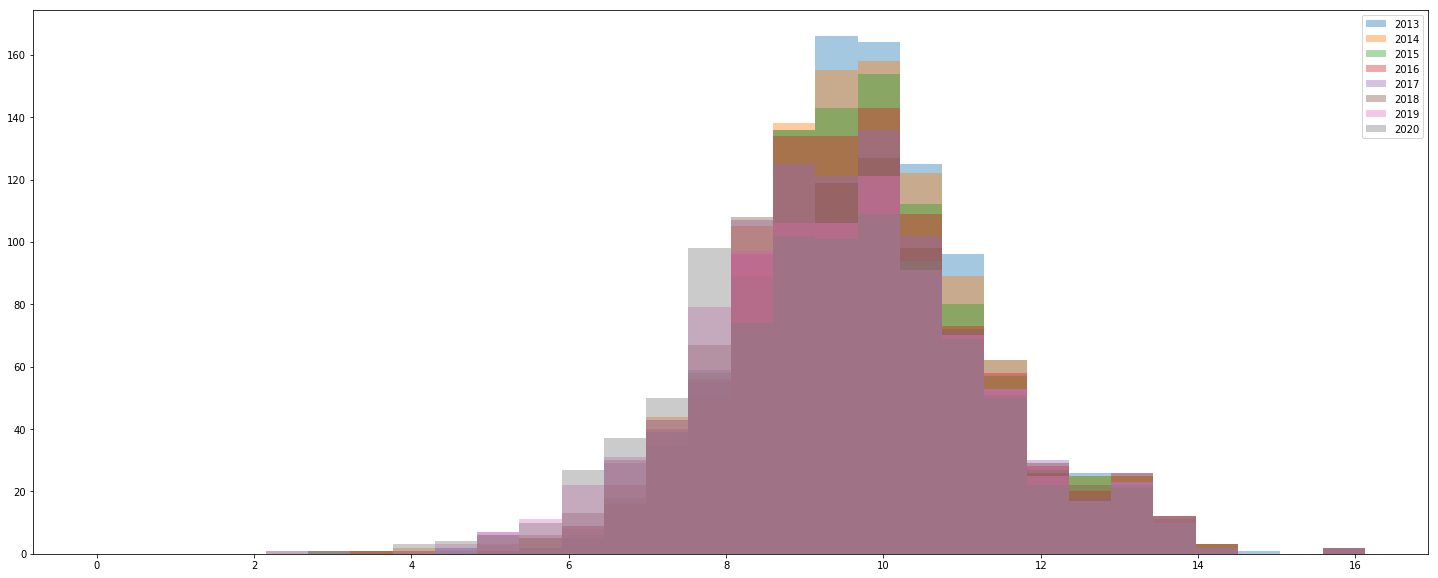

In [171]:
MIN, MAX = 1, 10000000
plt.figure(figsize=(25,10))

for year in allocationsPerYear:
    sns.distplot(
        np.log(np.array(allocationsPerYear[year])),
        bins=30,
        kde=False,
        hist_kws={
            "range": (np.log(MIN), np.log(MAX))
        },
        label=year
    )
plt.legend()
plt.show()

### Most carbonated installations' dynamics

In [100]:
sortedInstallations = sorted(
    installations,
    key=lambda installation: installation.allocations['2020'],
    reverse=True
)

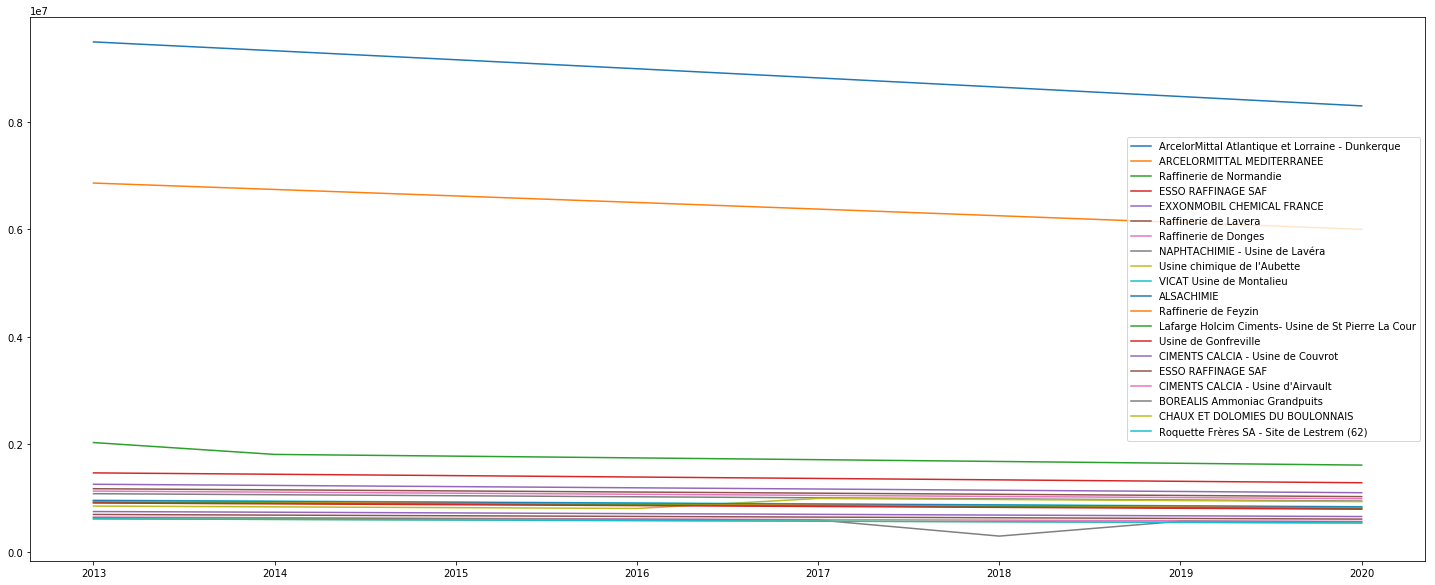

In [109]:
plt.figure(figsize=(25,10))
for installation in sortedInstallations[o:20]:
    plt.plot(YEARS, installation.allocations.values(), label=installation.installationName)
plt.legend()
plt.show()

### Yearly distribution of relative trends

On mesure ici pour une année `n` de combien les émissions ont diminué par rapport à l'année `n-1`

In [111]:
relativeChangesPerYear = {}
for year in YEARS[1:]:
    previousYear = str(int(year) - 1)
    relativeChanges = []
    for installation in installations:
        currentYearOk = installation.allocations[year] is not None and installation.allocations[year] != 0
        previousYearOk = installation.allocations[previousYear] is not None and installation.allocations[previousYear] != 0
        if currentYearOk and previousYearOk:
            r = (installation.allocations[year] - installation.allocations[previousYear]) / installation.allocations[previousYear]
            relativeChanges.append(r)
    relativeChangesPerYear[year] = relativeChanges

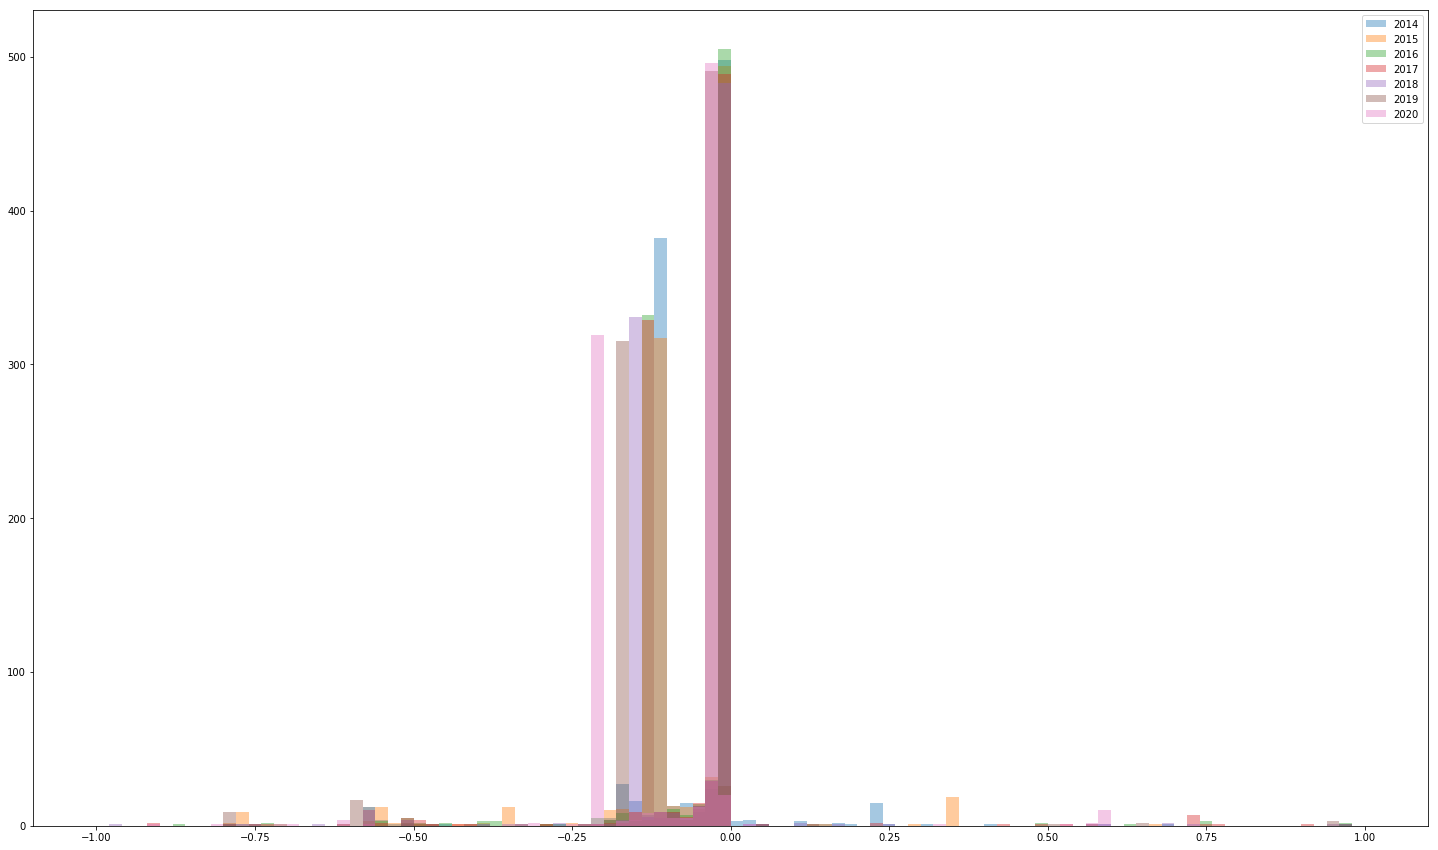

In [200]:
MIN, MAX = -1, 1
plt.figure(figsize=(25,15))

for year in relativeChangesPerYear:
    sns.distplot(
#         relativeChangesPerYear[year],
        list(filter(lambda x: x < MAX, relativeChangesPerYear[year])),
        label=year,
        bins=100,
        kde=False,
        hist_kws={
            "range": (MIN, MAX)
        }
    )
plt.legend()
plt.show()

#### Closer look at distributions for installations reducing their emissions

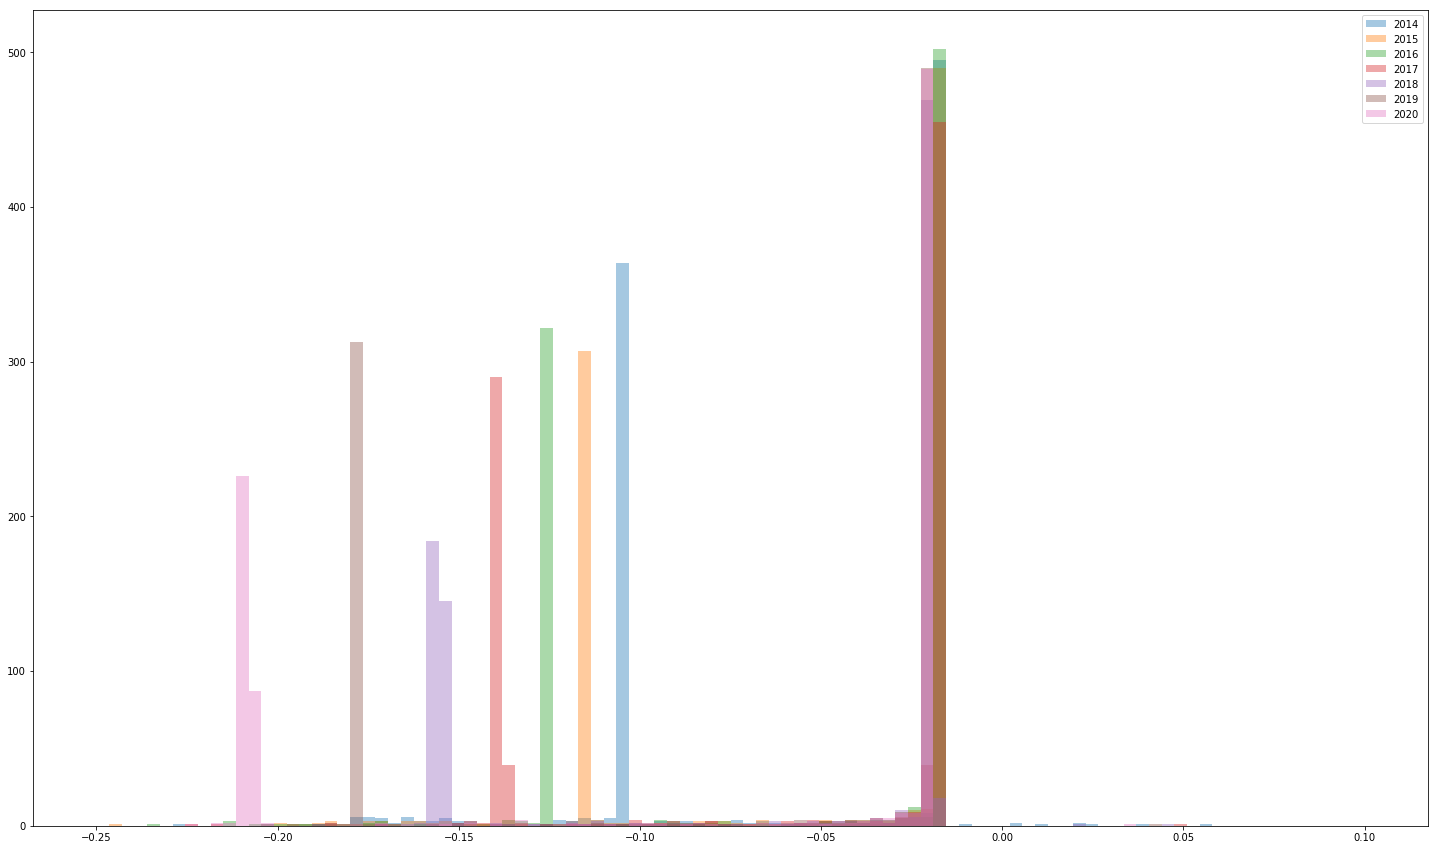

In [201]:
MIN, MAX = -0.25, 0.1
plt.figure(figsize=(25,15))

for year in relativeChangesPerYear:
    sns.distplot(
#         relativeChangesPerYear[year],
        list(filter(lambda x: x < MAX, relativeChangesPerYear[year])),
        label=year,
        bins=100,
        kde=False,
        hist_kws={
            "range": (MIN, MAX)
        }
    )
plt.legend()
plt.show()

#### Even closer look

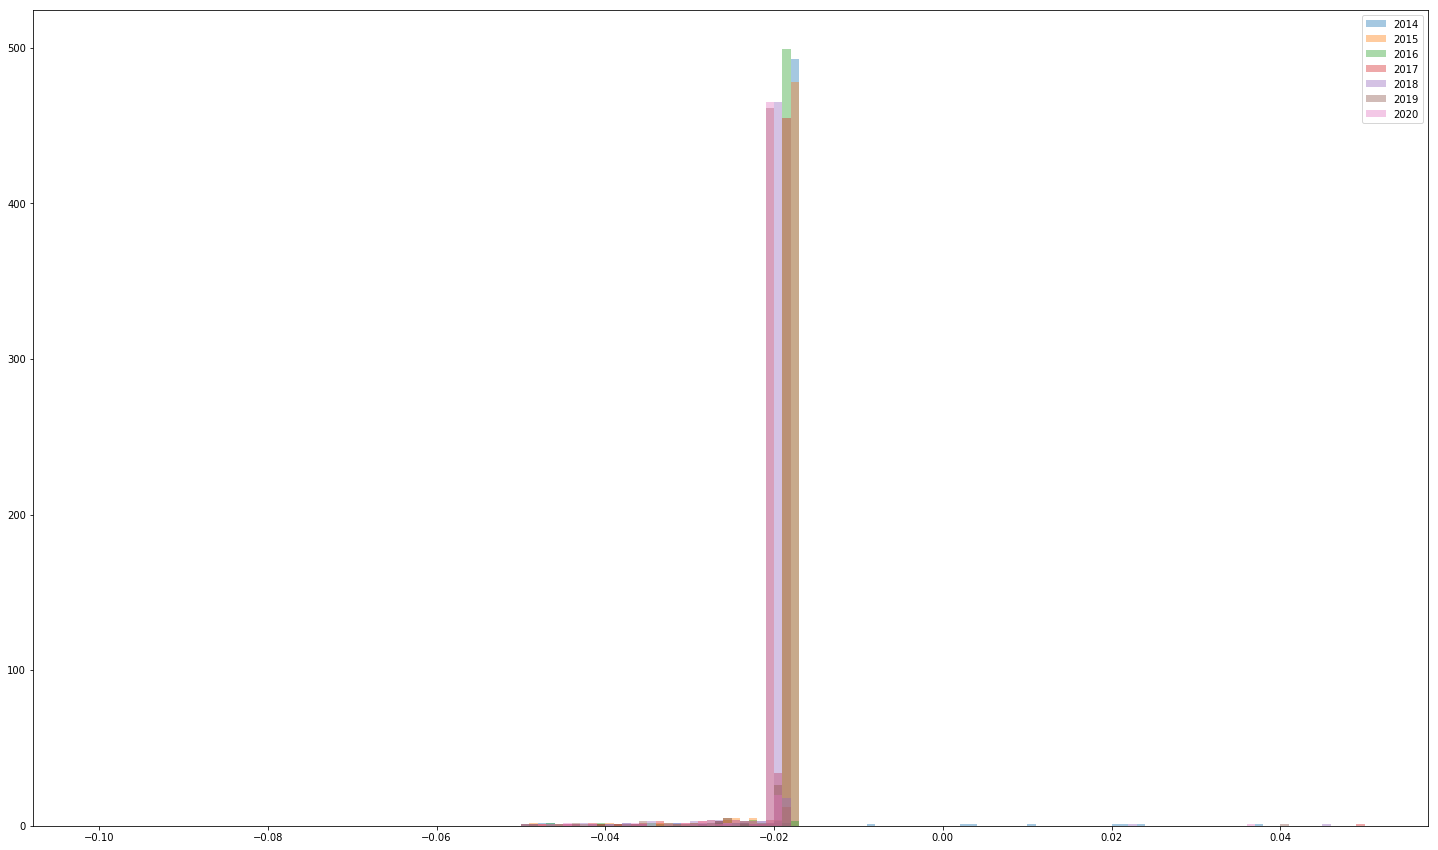

In [204]:
MIN, MAX = -0.05, 0.05
plt.figure(figsize=(25,15))

for year in relativeChangesPerYear:
    sns.distplot(
#         relativeChangesPerYear[year],
        list(filter(lambda x: x < MAX, relativeChangesPerYear[year])),
        label=year,
        bins=100,
        kde=False,
        hist_kws={
            "range": (MIN, MAX)
        }
    )
plt.legend()
plt.show()

### 2020's relative trend vs total emissions

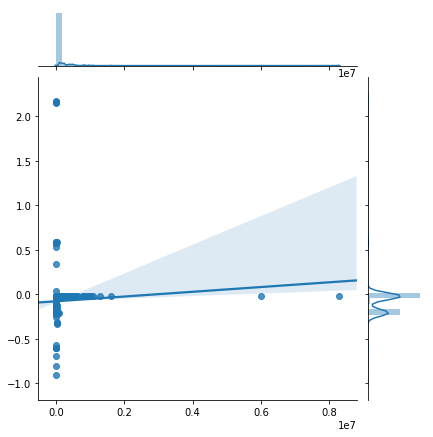

In [173]:
filteredInstallations = list(filter(lambda x: x.allocations['2019'] is not None and x.allocations['2019'] > 0 and x.allocations['2020'] is not None and x.allocations['2020'] > 0, installations))
x = [installation.allocations['2020'] for installation in filteredInstallations]
y = [(installation.allocations['2020'] - installation.allocations['2019']) / installation.allocations['2019'] for installation in filteredInstallations]

g = sns.JointGrid(
    np.array(x),
    np.array(y)
)
g.plot(sns.regplot, sns.distplot)

### 2020's relative trend vs _log_ total emissions

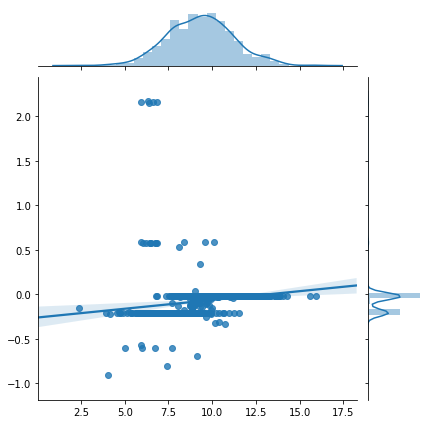

In [164]:
filteredInstallations = list(filter(lambda x: x.allocations['2019'] is not None and x.allocations['2019'] > 0 and x.allocations['2020'] is not None and x.allocations['2020'] > 0, installations))
x = [installation.allocations['2020'] for installation in filteredInstallations]
y = [(installation.allocations['2020'] - installation.allocations['2019']) / installation.allocations['2019'] for installation in filteredInstallations]

g = sns.JointGrid(
    np.log(np.array(x)),
    np.array(y)
)
g.plot(sns.regplot, sns.distplot)